In [3]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imodelsx.process_results
from collections import defaultdict
import numpy as np
import viz
import transformers
import sys
import tprompt.utils
from os.path import join
import datasets
from typing import Dict, List
from sklearn.tree import plot_tree

from abc import ABC, abstractmethod
import logging
import math
import random
import imodels
import imodelsx.util
import imodelsx.metrics
import numpy as np
import tprompt.utils
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import torch.cuda
import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.base import BaseEstimator, ClassifierMixin
sys.path.append('../experiments/')

from tprompt.api import TreePromptClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dset_train = datasets.load_dataset('rotten_tomatoes')['train']
dset_train = dset_train.select(np.random.choice(len(dset_train), size=100, replace=False))
dset_val = datasets.load_dataset('rotten_tomatoes')['validation']
dset_val = dset_val.select(np.random.choice(len(dset_val), size=100, replace=False))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
prompts = [
    "This movie is",
    " Positive or Negative? The movie was",
    " The sentiment of the movie was",
    " The plot of the movie was really",
    " The acting in the movie was",
]
verbalizer = {0: " Negative.", 1: " Positive."}
m = TreePromptClassifier(
    checkpoint="gpt2",
    prompts=prompts,
    verbalizer=verbalizer,
    cache_prompt_features_dir=None, #'cache_prompt_features_dir/gp2',
)
m.fit(dset_train["text"], dset_train["label"])

Prompt 0: This movie is


Prompt 1:  Positive or Negative? The movie was


Prompt 2:  The sentiment of the movie was


Prompt 3:  The plot of the movie was really


Prompt 4:  The acting in the movie was


TreePromptClassifier(cache_prompt_features_dir=None, checkpoint='gpt2',
                     prompts=['This movie is',
                              ' Positive or Negative? The movie was',
                              ' The sentiment of the movie was',
                              ' The plot of the movie was really',
                              ' The acting in the movie was'])

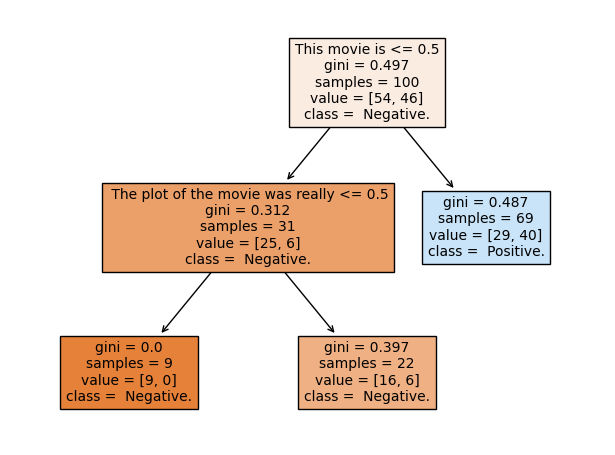

In [7]:
# visualize decision tree
plot_tree(
    m.clf_,
    fontsize=10,
    feature_names=m.feature_names_,
    class_names=list(verbalizer.values()),
    filled=True,
)
plt.show()

In [8]:
pd.DataFrame({'prompt': prompts, 'acc': m.prompt_accs_})

,prompt,acc
0,This movie is,0.65
1,Positive or Negative? The movie was,0.47
2,The sentiment of the movie was,0.50
3,The plot of the movie was really,0.55
4,The acting in the movie was,0.49


In [9]:
acc_test = np.mean(m.predict(dset_val["text"]) == dset_val["label"])
acc_test

Prompt 0: This movie is


Prompt 1:  The plot of the movie was really


0.7